In [1]:
import yfinance as yf
import pandas as pd

# List of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download historical price data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Display the first few rows of the data
data.head()


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-02 00:00:00+00:00,72.876114,94.900497,68.264961,153.938232,28.684000
2020-01-03 00:00:00+00:00,72.167610,93.748497,67.907845,152.021423,29.534000
2020-01-06 00:00:00+00:00,72.742661,95.143997,69.717865,152.414337,30.102667
2020-01-07 00:00:00+00:00,72.400536,95.343002,69.583206,151.024658,31.270666
2020-01-08 00:00:00+00:00,73.565193,94.598503,70.078476,153.430283,32.809334


In [2]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate the covariance matrix
cov_matrix = returns.cov()

# Display the first few rows of the returns and the covariance matrix
returns.head(), cov_matrix


(Ticker                         AAPL      AMZN     GOOGL      MSFT      TSLA
 Date                                                                       
 2020-01-03 00:00:00+00:00 -0.009722 -0.012139 -0.005231 -0.012452  0.029633
 2020-01-06 00:00:00+00:00  0.007968  0.014886  0.026654  0.002585  0.019255
 2020-01-07 00:00:00+00:00 -0.004703  0.002092 -0.001931 -0.009118  0.038801
 2020-01-08 00:00:00+00:00  0.016086 -0.007809  0.007118  0.015929  0.049205
 2020-01-09 00:00:00+00:00  0.021241  0.004799  0.010498  0.012493 -0.021945,
 Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
 Ticker                                                  
 AAPL    0.000541  0.000380  0.000370  0.000413  0.000550
 AMZN    0.000380  0.000606  0.000364  0.000378  0.000534
 GOOGL   0.000370  0.000364  0.000473  0.000395  0.000447
 MSFT    0.000413  0.000378  0.000395  0.000479  0.000499
 TSLA    0.000550  0.000534  0.000447  0.000499  0.002068)

In [3]:
import numpy as np
from scipy.optimize import minimize

# Number of assets
num_assets = len(tickers)

# Random initial weights
weights = np.random.random(num_assets)
weights /= np.sum(weights)

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, risk

# Function to minimize (negative Sharpe ratio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_risk

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Mean returns
mean_returns = returns.mean()

# Optimization
result = minimize(negative_sharpe_ratio, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = result.x

# Display the optimal weights
optimal_weights


array([2.90461577e-01, 0.00000000e+00, 4.09828421e-17, 2.75387352e-17,
       7.09538423e-01])

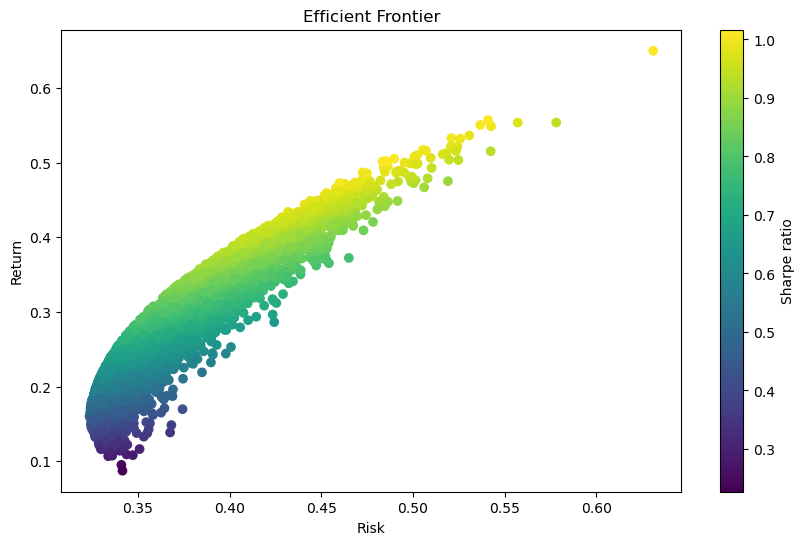

In [4]:
import matplotlib.pyplot as plt

# Function to calculate portfolio performance for a range of weights
def portfolio_performance_range(weights, mean_returns, cov_matrix):
    returns = []
    risks = []
    for weight in weights:
        p_returns, p_risk = portfolio_performance(weight, mean_returns, cov_matrix)
        returns.append(p_returns)
        risks.append(p_risk)
    return np.array(returns), np.array(risks)

# Generate random weights
random_weights = np.random.random((10000, num_assets))
random_weights /= np.sum(random_weights, axis=1)[:, np.newaxis]

# Calculate portfolio performance for random weights
random_returns, random_risks = portfolio_performance_range(random_weights, mean_returns, cov_matrix)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(random_risks, random_returns, c=(random_returns - 0.01) / random_risks, marker='o')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.colorbar(label='Sharpe ratio')
plt.title('Efficient Frontier')
plt.show()
